# Tree Datasets

From: https://www.nature.com/articles/s41597-023-02000-w#Sec8
## Canopy Height Model (CHM)
- Resolution: 1m spatial resolution:
- Values: The final CHM map has values ranging from 20 to 600 dm.
- Data Projection and Format for both CHM and Carbon Density: Both CHM and Carbon Density maps are in GeoTiff format under the NAD83 (National Spatial Reference System 2011) Universal Transverse Mercator Zone 18 North projection.
The CHM dataset was recorded in the unit of decimetre (dm) considering the precision of the LiDAR dataset (approximately 9 cm) and was saved in integer data format. Pixels with CHM values lower than 2 m were considered as non-tree, and masked out along with other non-vegetation land cover types. Pixels with CHM larger than 60 m were also masked out as non-trees to avoid misclassification with buildings since trees larger than 60 m were unlikely to exist in NYC. 

## Carbon density:
- Resolution: 1 m spatial
- Values: 0 - 410.1 ton/ha in floats
- Data Projection and Format: see above

A carbon density map over the tree canopy covered area for the entire NYC at 1 m spatial resolution in the unit of ton/ha. The Carbon density ranged from 0 to 410.1 ton/ha in float data format. 


## Individual Tree Dataset
- Refined polygons segmented from LiDAR-based CHM. 
- individual tree location by borough
- Attributes table of the tree crown polygons include the tree ID, polygon area (m2), tree top height (m), tree mean height (m), tree volume (m3), and carbon storage (predicted value, lower value, and upper value in ton).
- format: shapefiles


# Load Libraries

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray as rxr
import rasterio
from rasterio import plot as rioplot
from rasterio.plot import plotting_extent
import geopandas as gpd

import rasterstats as rs # zonalstatistics function used to extract raster values
import earthpy as et
import earthpy.plot as ep

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

# Load Rasters and Extract by Point
- code reference: https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/



In [20]:
# Load the CHM geotiff
file_name = '../data/greenness/NY_CHM_10Int260m.tif'

chm = rxr.open_rasterio(file_name, masked=True).squeeze()

file_name = '../data/greenness/NY_CHM529_CCset0_Carbondensity.tif'

# carbon density tiff
cd = rxr.open_rasterio(file_name, masked = True).squeeze()

type(chm)

xarray.core.dataarray.DataArray

In [16]:
# View summary statistics of canopy height model
print('Mean CHM (dm):', chm.mean().values)
print('Max CHM (dm):', chm.max().values)
print('Min CHM (dm):', chm.min().values)



Mean: 119.80263
Max: 599.0
Min: 21.0


In [22]:
# View summar statistics of the carbon density model
print('Mean Carbon Density:', cd.mean().values)
print('Max Carbon Density:', cd.max().values)
print('Min Carbon Density:', cd.min().values)



Mean Carbon Density: 10.303348
Max Carbon Density: 410.08502197265625
Min Carbon Density: 0.0


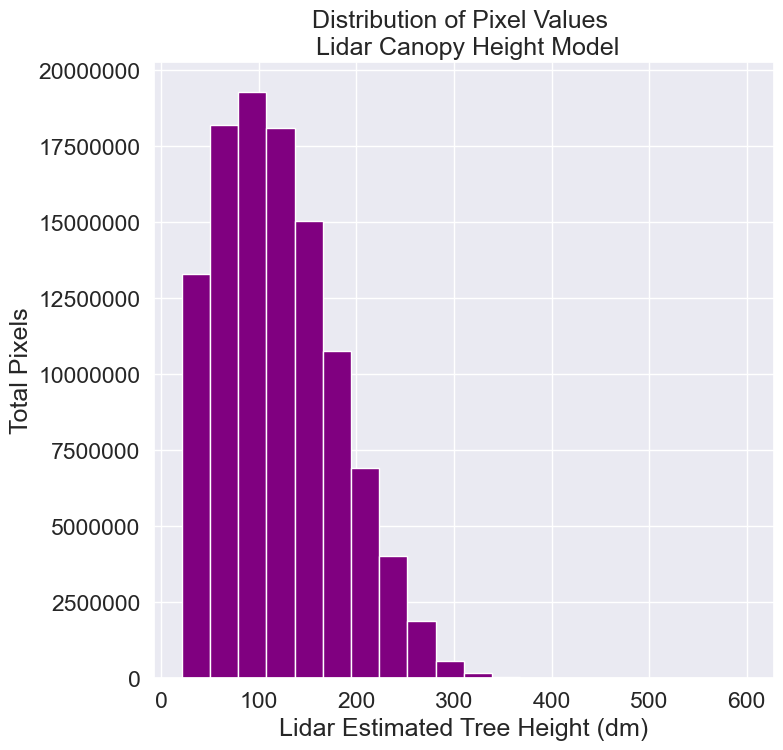

In [19]:
# Plot histrogram of CHM


# Explore the data by plotting a histogram with earthpy
ax = ep.hist(chm.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Lidar Estimated Tree Height (decimeter)",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Canopy Height Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

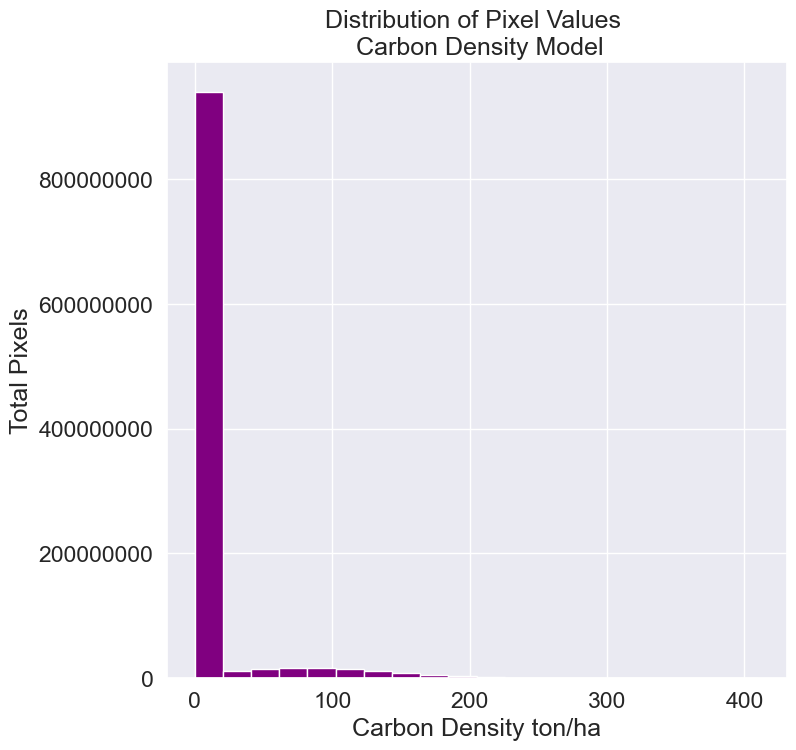

In [21]:
# Plot histrogram of carbon density


# Explore the data by plotting a histogram with earthpy
ax = ep.hist(cd.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Carbon Density ton/ha",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n Carbon Density Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

In [36]:
# Load in affordable housing subsidy dataset as output from 01
subsidies = pd.read_csv('../data/L1/subsidies.csv')

# Convert to spatial points
subsidies_gdf = gpd.GeoDataFrame(subsidies, geometry = gpd.points_from_xy(subsidies['longitude'], subsidies['latitude']), 
                                 crs = 4326)


type(subsidies_gdf)

# Convert to the same projection as the canopy height and carbon density models: 
# NAD83 (National Spatial Reference System 2011) Universal Transverse Mercator Zone 18 North projection
# ESPG: https://epsg.io/6347 - 6347

subsidies_gdf.to_crs(crs = 6347, inplace = True)

# ensure that is a points layer in the UTM projection
subsidies_gdf.head()

# Overlay points on top of raster data
A quick plot to check that subsidies actually overlay on top of the canopy height model. 
This is a good sanity check just to ensure data are in appropriate projection and location.

We have previously discussed the spatial extent of a raster. Here is where you will need to set the spatial extent when plotting raster using ep.plot_bands. If you do not specify a spatial extent, your raster will not line up properly with your geopandas object.

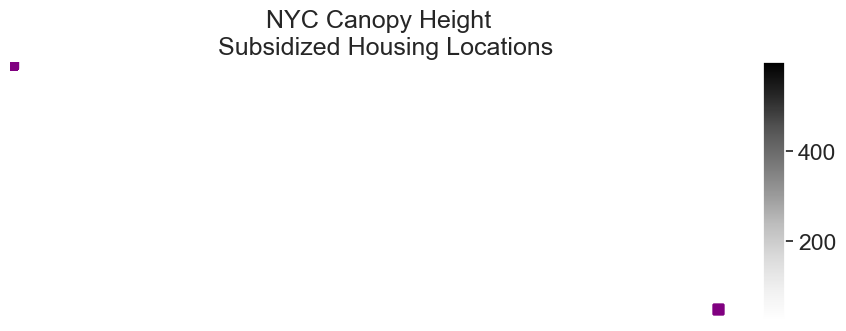

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

# We plot with the zeros in the data so the CHM can be better represented visually
ep.plot_bands(chm,
              extent=plotting_extent(chm,
                                     chm.rio.transform()),  # Set spatial extent
              cmap='Greys',
              title="NYC Canopy Height \n Subsidized Housing Locations",
              scale=False,
              ax=ax)

subsidies_gdf.plot(ax=ax,
                       marker='s',
                       markersize=45,
                       color='purple')
ax.set_axis_off()
plt.show()

# Buffer points and extract raster values
### Create buffer points with radius 300m (roughly equivalent to a city block)

In [40]:
# Create a buffered polygon layer from subsidized housing points
subsidies_poly = subsidies_gdf.copy()

# Buffer each point using a 500 meter circle radius
# and replace the point geometry with the new buffered geometry
subsidies_poly["geometry"] = subsidies_gdf.geometry.buffer(300)
subsidies_poly.head()

# EXPORT to new shapefile


# Export the buffered point layer as a shapefile to use in zonal stats
subsidies_buffer_path = os.path.join('../data/L1/', 
                                "subsidies_buffer.shp")

subsidies_poly.to_file(subsidies_buffer_path)

/var/folders/0p/rh9j3dm51wn8w8hpwmkfvqkw0000gn/T/ipykernel_49825/3472353041.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  subsidies_poly.to_file(subsidies_buffer_path)


### Extract pixel values for each buffer zone